In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Tue May 31 20:19:31 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.106.00   Driver Version: 460.106.00   CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  A30                 On   | 00000000:03:00.0 Off |                    0 |
| N/A   34C    P0    28W / 165W |      0MiB / 24258MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import tensorflow as tf
import timeit

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print(
      '\n\nThis error most likely means that this notebook is not '
      'configured to use a GPU.  Change this in Notebook Settings via the '
      'command palette (cmd/ctrl-shift-P) or the Edit menu.\n\n')
  raise SystemError('GPU device not found')

def cpu():
  with tf.device('/cpu:0'):
    random_image_cpu = tf.random.normal((100, 100, 100, 3))
    net_cpu = tf.keras.layers.Conv2D(32, 7)(random_image_cpu)
    return tf.math.reduce_sum(net_cpu)

def gpu():
  with tf.device('/device:GPU:0'):
    random_image_gpu = tf.random.normal((100, 100, 100, 3))
    net_gpu = tf.keras.layers.Conv2D(32, 7)(random_image_gpu)
    return tf.math.reduce_sum(net_gpu)
  
# We run each op once to warm up; see: https://stackoverflow.com/a/45067900
cpu()
gpu()

# Run the op several times.
print('Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images '
      '(batch x height x width x channel). Sum of ten runs.')
print('CPU (s):')
cpu_time = timeit.timeit('cpu()', number=10, setup="from __main__ import cpu")
print(cpu_time)
print('GPU (s):')
gpu_time = timeit.timeit('gpu()', number=10, setup="from __main__ import gpu")
print(gpu_time)
print('GPU speedup over CPU: {}x'.format(int(cpu_time/gpu_time)))

Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images (batch x height x width x channel). Sum of ten runs.
CPU (s):
0.6272111609869171
GPU (s):
0.031240320997312665
GPU speedup over CPU: 20x


In [3]:
import os
import glob
import pandas as pd
import tensorflow_io as tfio
import matplotlib.pyplot as plt
import numpy as np
import PIL
import pathlib
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [4]:
def train_model(img_dir, preprocess):

  data_dir = pathlib.Path(img_dir)

  batch_size = 64
  img_height = 128
  img_width = 128

  IMG_SHAPE = (img_height, img_width) + (3,)

  train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

  val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

  class_names = train_ds.class_names

  AUTOTUNE = tf.data.AUTOTUNE
  num_classes = len(class_names)

  train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
  val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

  data_augmentation = Sequential([
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomRotation(0.2),
  ])

  # Create the base model from the pre-trained model
  base_model = tf.keras.applications.xception.Xception(input_shape=IMG_SHAPE,
                                              include_top=False,
                                              weights='imagenet')
  
  base_model.trainable = False

  inputs = tf.keras.Input(shape=(128, 128, 3))
  x = data_augmentation(inputs)

  if preprocess == True:
    x = tf.keras.applications.xception.preprocess_input(x)
    print("Using preprocessing")

  x = base_model(x)
  x = tf.keras.layers.MaxPooling2D()(x)
  x = tf.keras.layers.Dropout(0.2)(x)
  x = tf.keras.layers.Flatten()(x)
  x = tf.keras.layers.Dense(512, activation='relu')(x)
  x = tf.keras.layers.Dropout(0.2)(x)
  x = tf.keras.layers.Dense(128, activation='relu')(x)
  outputs = tf.keras.layers.Dense(5)(x)
  model = tf.keras.Model(inputs, outputs)

  base_learning_rate = 0.0005

  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

  epochs=100
  history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
  )

  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs_range = range(epochs)

  plt.figure(figsize=(16, 6))
  plt.subplot(1, 2, 1)
  plt.plot(epochs_range, acc, label='Training Accuracy')
  plt.plot(epochs_range, val_acc, label='Validation Accuracy')
  plt.legend(loc='lower right')
  plt.title('Training and Validation Accuracy')

  plt.subplot(1, 2, 2)
  plt.plot(epochs_range, loss, label='Training Loss')
  plt.plot(epochs_range, val_loss, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.title('Training and Validation Loss')
  plt.show()
    
  return {'acc': acc, 'val_acc': val_acc, 'loss': loss, 'val_loss': val_loss}

Found 28793 files belonging to 5 classes.
Using 23035 files for training.
Found 28793 files belonging to 5 classes.
Using 5758 files for validation.
83697664/83683744 [==============================] - 73s 1us/step
Using preprocessing
Epoch 1/100
360/360 [==============================] - 20s 41ms/step - loss: 0.8332 - accuracy: 0.6474 - val_loss: 0.7259 - val_accuracy: 0.6863
Epoch 2/100
360/360 [==============================] - 16s 45ms/step - loss: 0.7296 - accuracy: 0.6891 - val_loss: 0.6908 - val_accuracy: 0.6987
Epoch 3/100
360/360 [==============================] - 13s 36ms/step - loss: 0.7049 - accuracy: 0.6966 - val_loss: 0.6929 - val_accuracy: 0.7006
Epoch 4/100
360/360 [==============================] - 13s 36ms/step - loss: 0.6921 - accuracy: 0.7033 - val_loss: 0.7070 - val_accuracy: 0.6935
Epoch 5/100
360/360 [==============================] - 13s 37ms/step - loss: 0.6822 - accuracy: 0.7084 - val_loss: 0.6663 - val_accuracy: 0.7136
Epoch 6/100
360/360 [===================

360/360 [==============================] - 12s 35ms/step - loss: 0.5742 - accuracy: 0.7595 - val_loss: 0.6032 - val_accuracy: 0.7442
Epoch 55/100
360/360 [==============================] - 13s 35ms/step - loss: 0.5711 - accuracy: 0.7588 - val_loss: 0.6111 - val_accuracy: 0.7404
Epoch 56/100
360/360 [==============================] - 12s 33ms/step - loss: 0.5751 - accuracy: 0.7576 - val_loss: 0.6013 - val_accuracy: 0.7416
Epoch 57/100
360/360 [==============================] - 12s 34ms/step - loss: 0.5771 - accuracy: 0.7576 - val_loss: 0.6051 - val_accuracy: 0.7437
Epoch 58/100
360/360 [==============================] - 12s 34ms/step - loss: 0.5703 - accuracy: 0.7557 - val_loss: 0.6021 - val_accuracy: 0.7437
Epoch 59/100
360/360 [==============================] - 12s 35ms/step - loss: 0.5654 - accuracy: 0.7624 - val_loss: 0.5927 - val_accuracy: 0.7482
Epoch 60/100
360/360 [==============================] - 12s 34ms/step - loss: 0.5724 - accuracy: 0.7609 - val_loss: 0.6024 - val_accuracy

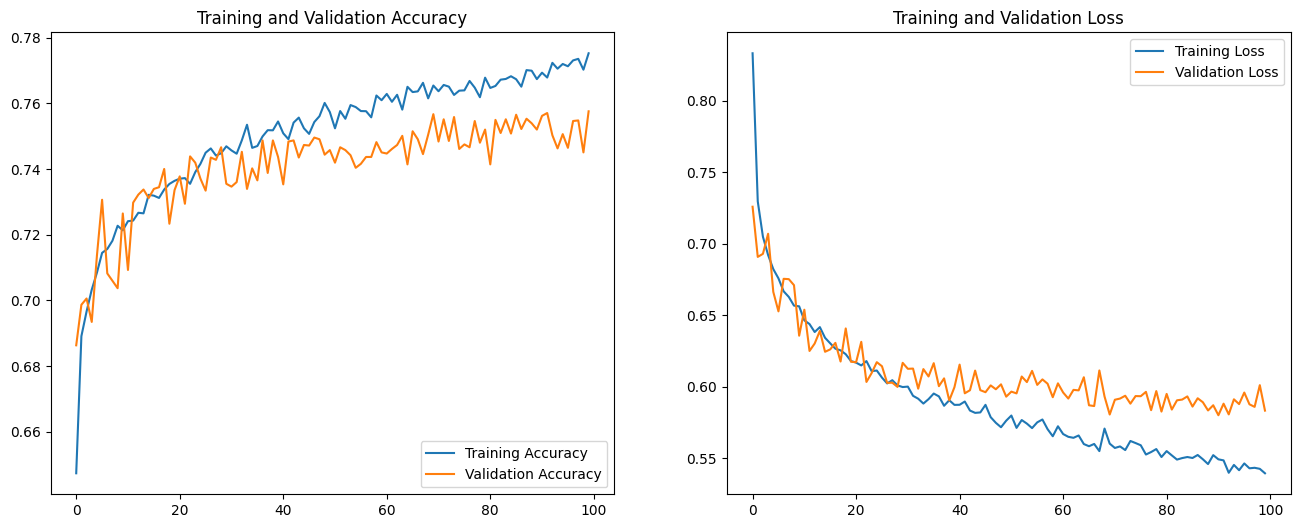

In [5]:
res_hls_pre = train_model('content/img_HLS', preprocess=True)

Found 28793 files belonging to 5 classes.
Using 23035 files for training.
Found 28793 files belonging to 5 classes.
Using 5758 files for validation.
Epoch 1/100
360/360 [==============================] - 17s 36ms/step - loss: 2.1827 - accuracy: 0.4099 - val_loss: 1.1409 - val_accuracy: 0.5007
Epoch 2/100
360/360 [==============================] - 12s 34ms/step - loss: 1.1654 - accuracy: 0.4953 - val_loss: 1.0833 - val_accuracy: 0.5160
Epoch 3/100
360/360 [==============================] - 12s 34ms/step - loss: 1.0964 - accuracy: 0.5225 - val_loss: 1.0224 - val_accuracy: 0.5516
Epoch 4/100
360/360 [==============================] - 13s 35ms/step - loss: 1.0560 - accuracy: 0.5407 - val_loss: 1.0231 - val_accuracy: 0.5406
Epoch 5/100
360/360 [==============================] - 13s 36ms/step - loss: 1.0326 - accuracy: 0.5568 - val_loss: 0.9970 - val_accuracy: 0.5573
Epoch 6/100
360/360 [==============================] - 12s 34ms/step - loss: 1.0221 - accuracy: 0.5590 - val_loss: 0.9603 - va

360/360 [==============================] - 12s 34ms/step - loss: 0.8913 - accuracy: 0.6283 - val_loss: 0.8508 - val_accuracy: 0.6462
Epoch 57/100
360/360 [==============================] - 13s 35ms/step - loss: 0.8916 - accuracy: 0.6301 - val_loss: 0.8742 - val_accuracy: 0.6322
Epoch 58/100
360/360 [==============================] - 12s 35ms/step - loss: 0.8885 - accuracy: 0.6305 - val_loss: 0.8537 - val_accuracy: 0.6501
Epoch 59/100
360/360 [==============================] - 12s 33ms/step - loss: 0.8984 - accuracy: 0.6277 - val_loss: 0.8501 - val_accuracy: 0.6494
Epoch 60/100
360/360 [==============================] - 12s 33ms/step - loss: 0.8927 - accuracy: 0.6262 - val_loss: 0.8641 - val_accuracy: 0.6391
Epoch 61/100
360/360 [==============================] - 12s 34ms/step - loss: 0.8915 - accuracy: 0.6271 - val_loss: 0.8576 - val_accuracy: 0.6403
Epoch 62/100
360/360 [==============================] - 12s 35ms/step - loss: 0.8855 - accuracy: 0.6304 - val_loss: 0.8643 - val_accuracy

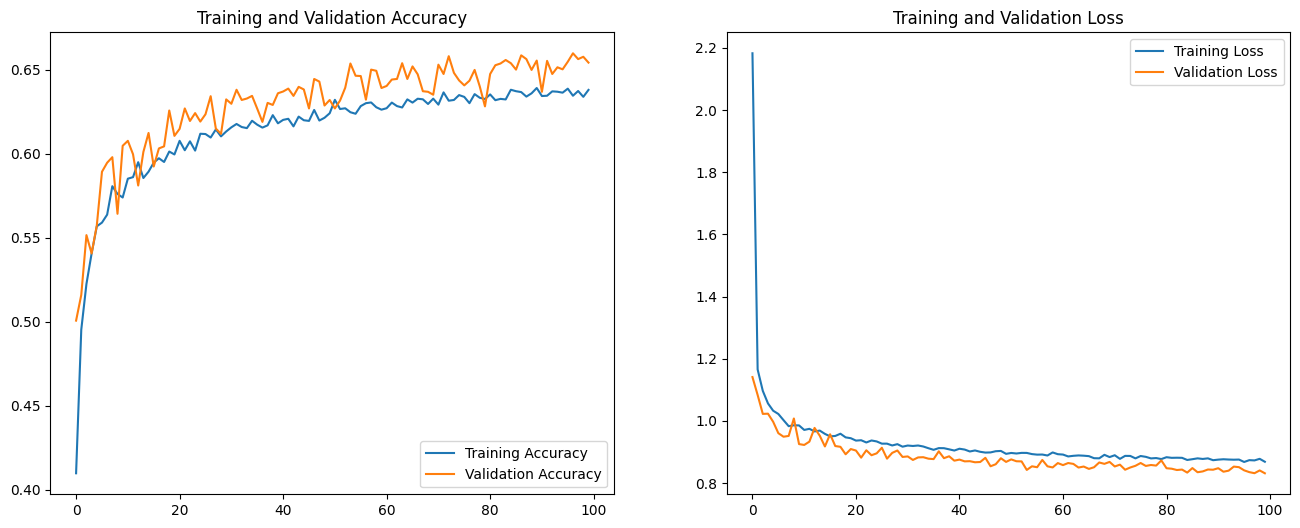

In [6]:
res_hls_nonpre = train_model('content/img_HLS', preprocess=False)

Found 28793 files belonging to 5 classes.
Using 23035 files for training.
Found 28793 files belonging to 5 classes.
Using 5758 files for validation.
Using preprocessing
Epoch 1/100
360/360 [==============================] - 16s 35ms/step - loss: 0.6744 - accuracy: 0.7213 - val_loss: 0.5787 - val_accuracy: 0.7510
Epoch 2/100
360/360 [==============================] - 12s 33ms/step - loss: 0.5702 - accuracy: 0.7653 - val_loss: 0.5252 - val_accuracy: 0.7919
Epoch 3/100
360/360 [==============================] - 12s 34ms/step - loss: 0.5487 - accuracy: 0.7728 - val_loss: 0.5276 - val_accuracy: 0.7833
Epoch 4/100
360/360 [==============================] - 12s 34ms/step - loss: 0.5289 - accuracy: 0.7830 - val_loss: 0.4822 - val_accuracy: 0.8020
Epoch 5/100
360/360 [==============================] - 12s 34ms/step - loss: 0.5186 - accuracy: 0.7898 - val_loss: 0.4793 - val_accuracy: 0.8025
Epoch 6/100
360/360 [==============================] - 12s 33ms/step - loss: 0.5071 - accuracy: 0.7919 - v

360/360 [==============================] - 12s 34ms/step - loss: 0.3979 - accuracy: 0.8420 - val_loss: 0.4056 - val_accuracy: 0.8329
Epoch 57/100
360/360 [==============================] - 12s 34ms/step - loss: 0.3934 - accuracy: 0.8430 - val_loss: 0.4077 - val_accuracy: 0.8406
Epoch 58/100
360/360 [==============================] - 12s 34ms/step - loss: 0.4004 - accuracy: 0.8395 - val_loss: 0.4146 - val_accuracy: 0.8395
Epoch 59/100
360/360 [==============================] - 12s 33ms/step - loss: 0.3957 - accuracy: 0.8425 - val_loss: 0.4065 - val_accuracy: 0.8404
Epoch 60/100
360/360 [==============================] - 12s 33ms/step - loss: 0.3946 - accuracy: 0.8434 - val_loss: 0.4163 - val_accuracy: 0.8361
Epoch 61/100
360/360 [==============================] - 12s 34ms/step - loss: 0.3978 - accuracy: 0.8417 - val_loss: 0.4049 - val_accuracy: 0.8388
Epoch 62/100
360/360 [==============================] - 12s 34ms/step - loss: 0.3919 - accuracy: 0.8419 - val_loss: 0.4131 - val_accuracy

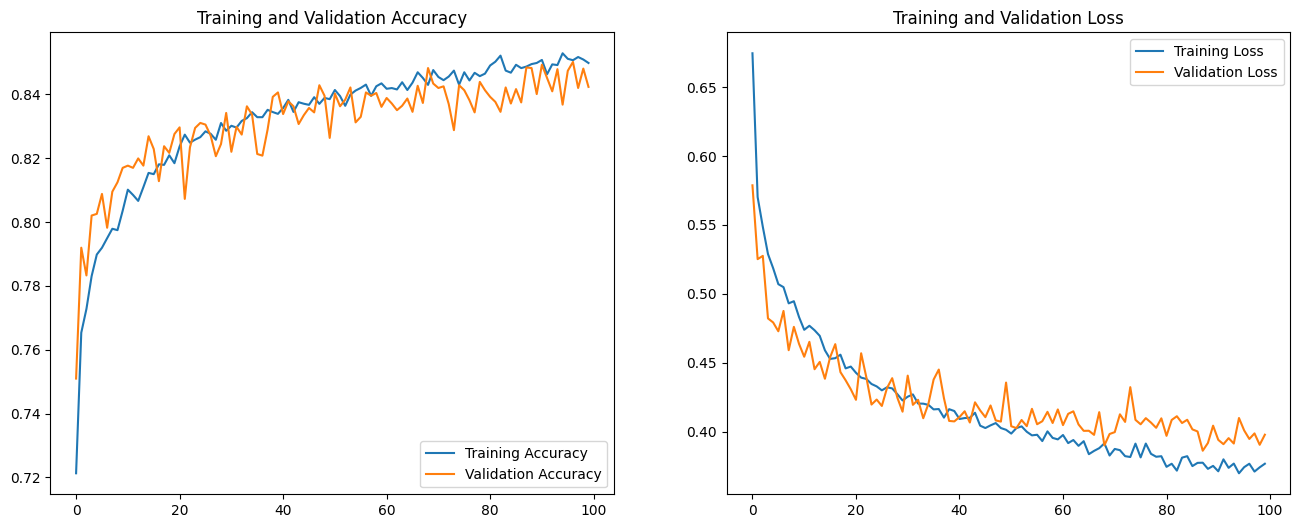

In [7]:
res_luv_pre = train_model('content/img_Luv', preprocess=True)

Found 28793 files belonging to 5 classes.
Using 23035 files for training.
Found 28793 files belonging to 5 classes.
Using 5758 files for validation.
Epoch 1/100
360/360 [==============================] - 16s 35ms/step - loss: 5.4416 - accuracy: 0.3783 - val_loss: 1.1628 - val_accuracy: 0.4575
Epoch 2/100
360/360 [==============================] - 12s 33ms/step - loss: 1.2265 - accuracy: 0.4417 - val_loss: 1.0426 - val_accuracy: 0.5245
Epoch 3/100
360/360 [==============================] - 12s 34ms/step - loss: 1.1343 - accuracy: 0.4877 - val_loss: 1.0213 - val_accuracy: 0.5096
Epoch 4/100
360/360 [==============================] - 12s 34ms/step - loss: 1.0837 - accuracy: 0.5181 - val_loss: 0.9832 - val_accuracy: 0.5257
Epoch 5/100
360/360 [==============================] - 12s 34ms/step - loss: 1.0578 - accuracy: 0.5337 - val_loss: 0.9470 - val_accuracy: 0.5804
Epoch 6/100
360/360 [==============================] - 12s 34ms/step - loss: 1.0714 - accuracy: 0.5193 - val_loss: 0.9652 - va

360/360 [==============================] - 12s 34ms/step - loss: 0.8752 - accuracy: 0.6393 - val_loss: 0.7915 - val_accuracy: 0.6933
Epoch 57/100
360/360 [==============================] - 12s 33ms/step - loss: 0.8778 - accuracy: 0.6387 - val_loss: 0.8121 - val_accuracy: 0.6837
Epoch 58/100
360/360 [==============================] - 12s 33ms/step - loss: 0.8755 - accuracy: 0.6387 - val_loss: 0.8216 - val_accuracy: 0.6896
Epoch 59/100
360/360 [==============================] - 12s 33ms/step - loss: 0.8721 - accuracy: 0.6412 - val_loss: 0.7753 - val_accuracy: 0.6855
Epoch 60/100
360/360 [==============================] - 12s 33ms/step - loss: 0.8735 - accuracy: 0.6442 - val_loss: 0.7633 - val_accuracy: 0.6898
Epoch 61/100
360/360 [==============================] - 12s 33ms/step - loss: 0.8790 - accuracy: 0.6362 - val_loss: 0.7887 - val_accuracy: 0.7060
Epoch 62/100
360/360 [==============================] - 12s 33ms/step - loss: 0.8814 - accuracy: 0.6395 - val_loss: 0.7816 - val_accuracy

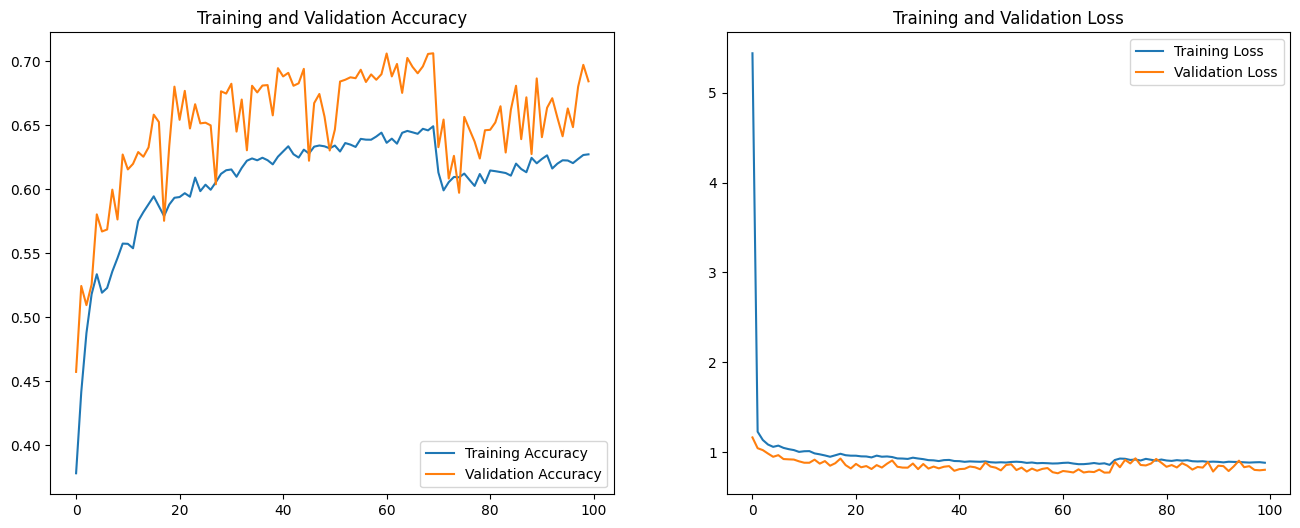

In [8]:
res_luv_nonpre = train_model('content/img_Luv', preprocess=False)

Found 28793 files belonging to 5 classes.
Using 23035 files for training.
Found 28793 files belonging to 5 classes.
Using 5758 files for validation.
Using preprocessing
Epoch 1/100
360/360 [==============================] - 16s 36ms/step - loss: 0.7094 - accuracy: 0.7034 - val_loss: 0.5847 - val_accuracy: 0.7496
Epoch 2/100
360/360 [==============================] - 13s 37ms/step - loss: 0.5961 - accuracy: 0.7499 - val_loss: 0.6144 - val_accuracy: 0.7449
Epoch 3/100
360/360 [==============================] - 12s 34ms/step - loss: 0.5790 - accuracy: 0.7568 - val_loss: 0.5648 - val_accuracy: 0.7631
Epoch 4/100
360/360 [==============================] - 12s 34ms/step - loss: 0.5622 - accuracy: 0.7622 - val_loss: 0.5684 - val_accuracy: 0.7668
Epoch 5/100
360/360 [==============================] - 12s 33ms/step - loss: 0.5542 - accuracy: 0.7672 - val_loss: 0.5360 - val_accuracy: 0.7624
Epoch 6/100
360/360 [==============================] - 12s 33ms/step - loss: 0.5397 - accuracy: 0.7730 - v

360/360 [==============================] - 13s 35ms/step - loss: 0.4399 - accuracy: 0.8204 - val_loss: 0.4399 - val_accuracy: 0.8262
Epoch 57/100
360/360 [==============================] - 12s 34ms/step - loss: 0.4428 - accuracy: 0.8176 - val_loss: 0.4373 - val_accuracy: 0.8246
Epoch 58/100
360/360 [==============================] - 12s 33ms/step - loss: 0.4315 - accuracy: 0.8221 - val_loss: 0.4506 - val_accuracy: 0.8229
Epoch 59/100
360/360 [==============================] - 12s 33ms/step - loss: 0.4391 - accuracy: 0.8215 - val_loss: 0.4339 - val_accuracy: 0.8268
Epoch 60/100
360/360 [==============================] - 12s 33ms/step - loss: 0.4376 - accuracy: 0.8205 - val_loss: 0.4463 - val_accuracy: 0.8178
Epoch 61/100
360/360 [==============================] - 12s 33ms/step - loss: 0.4339 - accuracy: 0.8217 - val_loss: 0.4386 - val_accuracy: 0.8239
Epoch 62/100
360/360 [==============================] - 12s 33ms/step - loss: 0.4349 - accuracy: 0.8236 - val_loss: 0.4331 - val_accuracy

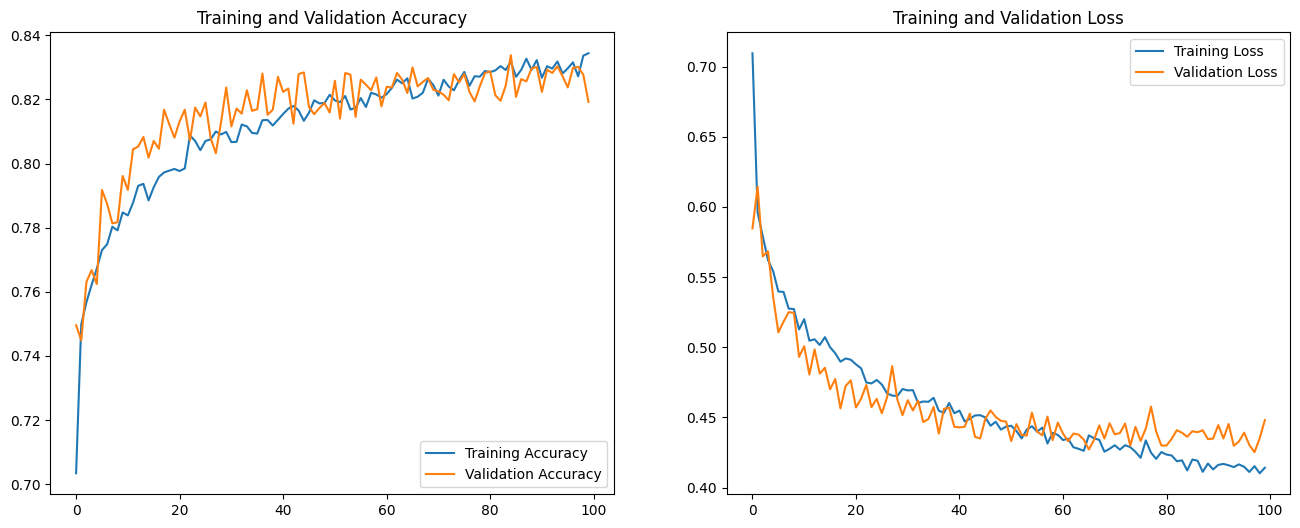

In [9]:
res_ycrcb_pre = train_model('content/img_YCrCb', preprocess=True)

Found 28793 files belonging to 5 classes.
Using 23035 files for training.
Found 28793 files belonging to 5 classes.
Using 5758 files for validation.
Epoch 1/100
360/360 [==============================] - 16s 35ms/step - loss: 5.8195 - accuracy: 0.3395 - val_loss: 1.2453 - val_accuracy: 0.4276
Epoch 2/100
360/360 [==============================] - 12s 33ms/step - loss: 1.3078 - accuracy: 0.3789 - val_loss: 1.1904 - val_accuracy: 0.4443
Epoch 3/100
360/360 [==============================] - 12s 34ms/step - loss: 1.2550 - accuracy: 0.4156 - val_loss: 1.1302 - val_accuracy: 0.4970
Epoch 4/100
360/360 [==============================] - 12s 34ms/step - loss: 1.2154 - accuracy: 0.4463 - val_loss: 1.0970 - val_accuracy: 0.5446
Epoch 5/100
360/360 [==============================] - 12s 34ms/step - loss: 1.1826 - accuracy: 0.4702 - val_loss: 1.0409 - val_accuracy: 0.5733
Epoch 6/100
360/360 [==============================] - 12s 35ms/step - loss: 1.1648 - accuracy: 0.4741 - val_loss: 1.0813 - va

360/360 [==============================] - 12s 33ms/step - loss: 1.0483 - accuracy: 0.5279 - val_loss: 0.9268 - val_accuracy: 0.5688
Epoch 57/100
360/360 [==============================] - 12s 34ms/step - loss: 1.0486 - accuracy: 0.5312 - val_loss: 0.9452 - val_accuracy: 0.5686
Epoch 58/100
360/360 [==============================] - 12s 34ms/step - loss: 1.0451 - accuracy: 0.5306 - val_loss: 0.9016 - val_accuracy: 0.5830
Epoch 59/100
360/360 [==============================] - 13s 35ms/step - loss: 1.0524 - accuracy: 0.5278 - val_loss: 0.9161 - val_accuracy: 0.5940
Epoch 60/100
360/360 [==============================] - 12s 34ms/step - loss: 1.0359 - accuracy: 0.5359 - val_loss: 0.9017 - val_accuracy: 0.5900
Epoch 61/100
360/360 [==============================] - 12s 34ms/step - loss: 1.0482 - accuracy: 0.5303 - val_loss: 0.9030 - val_accuracy: 0.5868
Epoch 62/100
360/360 [==============================] - 12s 34ms/step - loss: 1.0421 - accuracy: 0.5276 - val_loss: 0.9068 - val_accuracy

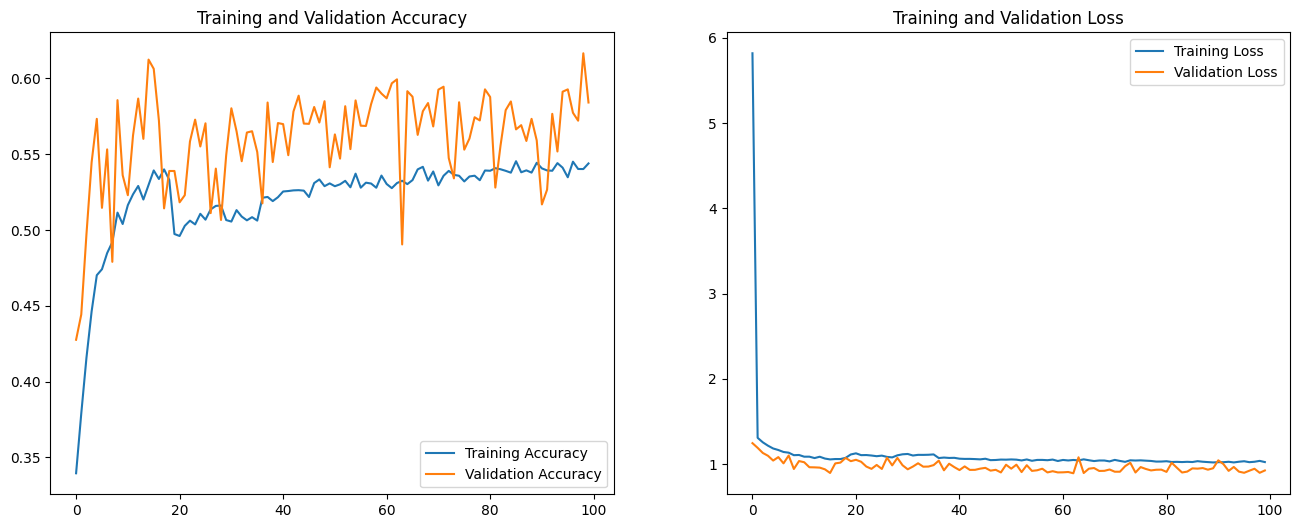

In [10]:
res_ycrcb_nonpre = train_model('content/img_YCrCb', preprocess=False)

In [11]:
pd.DataFrame(res_hls_pre).to_csv("xception_nontrainable/res_hls_pre.csv", index=False)
pd.DataFrame(res_hls_nonpre).to_csv("xception_nontrainable/res_hls_nonpre.csv", index=False)
pd.DataFrame(res_luv_pre).to_csv("xception_nontrainable/res_luv_pre.csv", index=False)
pd.DataFrame(res_luv_nonpre).to_csv("xception_nontrainable/res_luv_nonpre.csv", index=False)
pd.DataFrame(res_ycrcb_pre).to_csv("xception_nontrainable/res_ycrcb_pre.csv", index=False)
pd.DataFrame(res_ycrcb_nonpre).to_csv("xception_nontrainable/res_ycrcb_nonpre.csv", index=False)